<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter16/CLIP_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

import os
if not os.path.exists("MCVP2e-CLIP"):
  !git clone https://github.com/sizhky/MCVP2e-CLIP.git
  %pip install -r MCVP2e-CLIP/requirements.txt

In [2]:
%cd MCVP2e-CLIP

/content/MCVP2e-CLIP


In [3]:
import itertools
from torch_snippets import *
from clip.core import download_flickr8k_from_kaggle
from clip.config import ClipConfig
from clip.dataset import CLIPDataset
from clip.models import CLIP

In [4]:
%%writefile kaggle.json
{"username":"XXX","key":"XXX"}

Writing kaggle.json


Before running the next line of code,
ensure you are agreeing to kaggle’s terms in the webpage -
https://www.kaggle.com/datasets/adityajn105/flickr8k once.
Else the download wouldn’t happen

In [5]:
kaggle_json_path = P("kaggle.json")
data_download_path = P("/content/flickr-8k-kaggle/")
download_flickr8k_from_kaggle(kaggle_json_path, data_download_path)

df = pd.read_csv(data_download_path / "captions.txt")
df["id"] = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
df.to_csv(data_download_path / "captions.csv")

[12/24/23 11:30:58] INFO     Loaded key from kaggle.json                                                                                          ]8;id=663220;file:///content/MCVP2e-CLIP/clip/core.py:15\core.py]8;;\:]8;id=669157;file:///content/MCVP2e-CLIP/clip/core.py:15#load_kaggle_key:15\load_kaggle_key:15]8;;\

Output()

[12/24/23 11:31:17] INFO     Downloading flickr8k data... - Completed in 19.11 s                                                                ]8;id=241765;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/logger.py:216\logger.py]8;;\:]8;id=717846;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/logger.py:216#notify_waiting:216\notify_waiting:216]8;;\

In [6]:
df.head()

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0


In [7]:
config = ClipConfig()
config.image_path = data_download_path / "Images"
config.captions_csv_path = data_download_path / "captions.csv"
# Make any other experiment changes, if you want to, below
config.debug = False  # Switch to True, in case you want to reduce the dataset size
config.epochs = 1
config.save_eval_and_logging_steps = 50

In [8]:
config

ClipConfig(debug=False, batch_size=32, num_workers=2, head_lr=0.001, image_encoder_lr=0.0001, text_encoder_lr=1e-05, patience=1, factor=0.8, epochs=1, device='cuda', model_name='resnet50', image_embedding=2048, text_embedding=768, max_length=200, pretrained=True, trainable=True, temperature=1.0, size=224, num_projection_layers=1, projection_dim=256, dropout=0.1, target_token_idx=0, save_eval_and_logging_steps=50)

In [9]:
trn_ds, val_ds = CLIPDataset.train_test_split(config)

model = CLIP(config).to(config.device)

params = [
    {"params": model.image_encoder.parameters(), "lr": config.image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": config.text_encoder_lr},
    {
        "params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ),
        "lr": config.head_lr,
        "weight_decay": config.weight_decay,
    },
]

optimizer = torch.optim.AdamW(params, weight_decay=0.0)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=config.patience, factor=config.factor
)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Output()

[12/24/23 11:35:00] INFO     Creating encoded captions for train dataset... - Completed in 10.58 s                                              ]8;id=545726;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/logger.py:216\logger.py]8;;\:]8;id=774864;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/logger.py:216#notify_waiting:216\notify_waiting:216]8;;\

Output()

[12/24/23 11:35:04] INFO     Creating encoded captions for valid dataset... - Completed in 3.48 s                                               ]8;id=898970;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/logger.py:216\logger.py]8;;\:]8;id=628693;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/logger.py:216#notify_waiting:216\notify_waiting:216]8;;\

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [10]:
from transformers import Trainer, TrainingArguments

# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",  # Output directory where checkpoints and logs will be saved.
    num_train_epochs=config.epochs,  # Total number of training epochs.
    per_device_train_batch_size=config.batch_size,  # Batch size per GPU.
    per_device_eval_batch_size=config.batch_size,  # Batch size for evaluation per GPU.
    evaluation_strategy="steps",  # Evaluation strategy (steps, epoch).
    logging_strategy="steps",  # Logging strategy (steps, epoch).
    save_strategy="steps",  # Save strategy (steps, epoch).
    save_total_limit=2,  # Limit the total amount of checkpoints.
    learning_rate=5e-5,  # Learning rate.
    logging_steps=config.save_eval_and_logging_steps,
    save_steps=config.save_eval_and_logging_steps,  # Save checkpoints every N steps.
    eval_steps=config.save_eval_and_logging_steps,  # Evaluate every N steps.
    logging_dir="./logs",  # Directory for storing logs.
    metric_for_best_model="loss",
    label_names=["image", "input_ids"],
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trn_ds,
    eval_dataset=val_ds,
    optimizers=(optimizer, lr_scheduler),  # Pass your custom optimizer here.
)

# Train the model
trainer.train()

Step,Training Loss,Validation Loss
50,7.787900,3.833392
100,3.644800,3.210788
150,2.911500,2.850900
200,2.393100,2.636560
250,2.092300,2.478194
300,1.913300,2.379836
350,1.692800,2.402525
400,1.531300,2.278651
450,1.381000,2.246091
500,1.337800,2.261762


KeyboardInterrupt: ignored

In [11]:
from clip.infer import get_image_embeddings, find_matches

# in case you want to load a pretrained model...
# model = CLIP.from_pretrained("results/checkpoint-550/", config)
# _ = model.to(config.device)

val_dl = DataLoader(
    val_ds,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    shuffle=False,
)

image_embeddings = get_image_embeddings(val_dl, model)

[12/24/23 12:05:24] INFO     Loaded weights from results/checkpoint-550/pytorch_model.bin to given model                                       ]8;id=234053;file:///content/MCVP2e-CLIP/clip/models.py:105\models.py]8;;\:]8;id=146316;file:///content/MCVP2e-CLIP/clip/models.py:105#from_pretrained:105\from_pretrained:105]8;;\

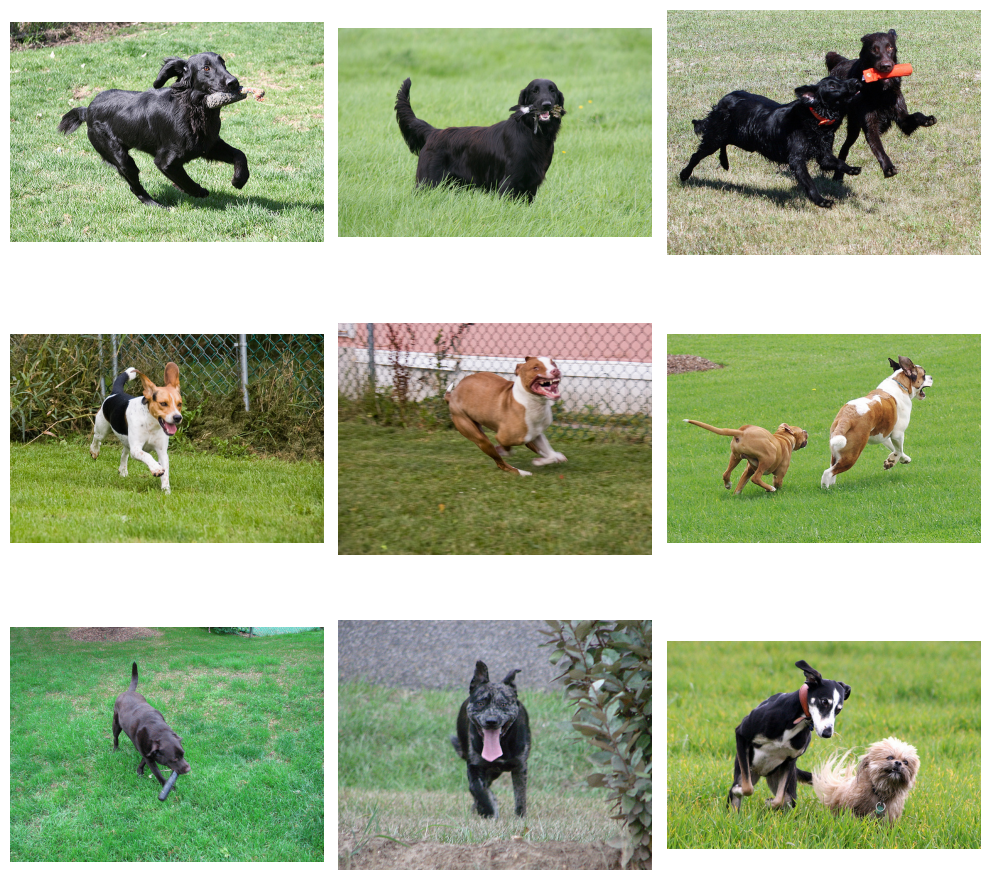

In [12]:
query="dog playing on grass"
find_matches(model, image_embeddings, query=query, image_filenames=val_dl.dataset.image_filenames)

In [ ]:
1

1